# Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_fscore_support, confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

c:\Users\Leonid\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка набора данных

In [2]:
# Load dataset
data = pd.read_csv('data\diabetes_prediction_dataset.csv')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Leonid\AppData\Local\Temp\ipykernel_8360\2579010693.py:2: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('data\diabetes_prediction_dataset.csv')


# Кодирование категориальных признаков

In [3]:
# Encoding categorical features
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
data['smoking_history'] = data['smoking_history'].astype('category').cat.codes


# Определение признаков (X) и целевой переменной (y)

In [4]:
# Define features and target
X = data.drop(columns=['diabetes'])
y = data['diabetes']


# Вычисление весов классов для балансировки

In [5]:
# Calculate class weights
class_weights = {0: len(y) / (2 * np.bincount(y)[0]), 
                 1: len(y) / (2 * np.bincount(y)[1])}

# Разделение данных на обучающую и тестовую выборки

In [6]:

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Обучение модели CatBoost

In [7]:
# Train CatBoost model
original_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False, random_seed=42)
original_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# Предсказания

In [8]:
# Predictions
y_pred = original_model.predict(X_test)
y_pred_proba = original_model.predict_proba(X_test)[:, 1]

# Оценка ROC AUC

In [9]:
# Metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9794653326904533


In [10]:
classification_report_str = classification_report(y_test, y_pred)
print("Отчет о классификации:\n", classification_report_str)

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.98      0.69      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



In [11]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Точность: {precision:.2f}, Полнота: {recall:.2f}, F1-мера: {f1:.2f}")

Точность: 0.98, Полнота: 0.69, F1-мера: 0.81


# Матрица ошибок

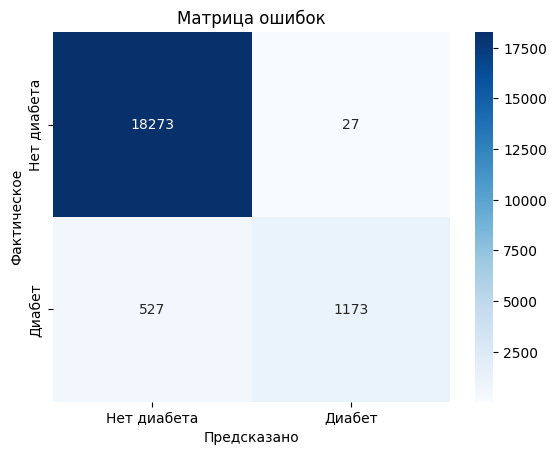

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Нет диабета', 'Диабет'], yticklabels=['Нет диабета', 'Диабет'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказано')
plt.ylabel('Фактическое')
plt.show()

# Важность признаков

In [13]:
# Feature Importance
feature_importances = original_model.get_feature_importance()
feature_names = X.columns

C:\Users\Leonid\AppData\Local\Temp\ipykernel_8360\4132272684.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette='viridis')


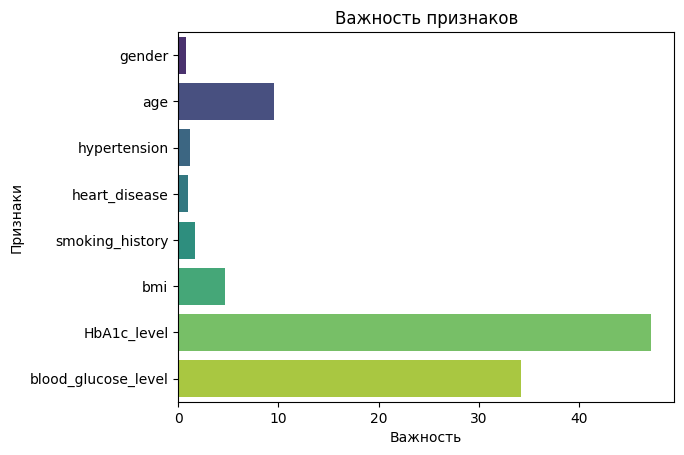

In [14]:
sns.barplot(x=feature_importances, y=feature_names, palette='viridis')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

# Корреляционная матрица

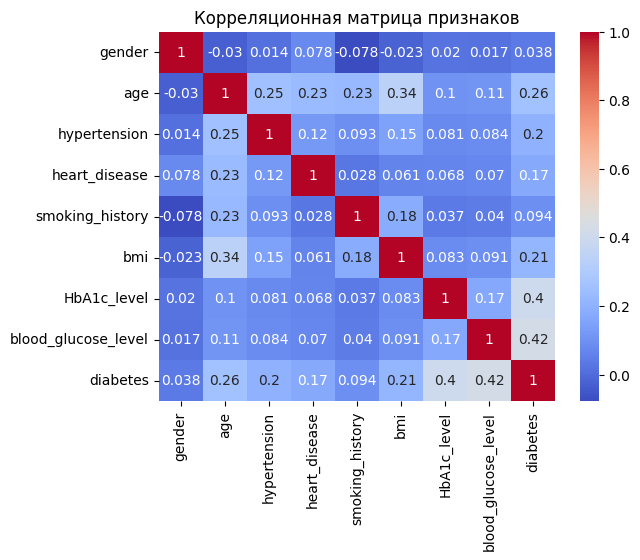

In [15]:
# Correlation Matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

# ROC AUC кривая

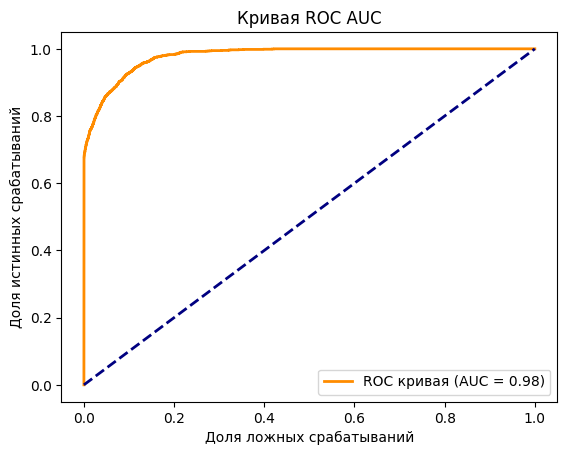

In [16]:
# Plot ROC AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Доля ложных срабатываний')
plt.ylabel('Доля истинных срабатываний')
plt.title('Кривая ROC AUC')
plt.legend(loc="lower right")
plt.show()

# Сохранение обученной модели в файл

In [17]:
# Save the trained optimal model to a .cbm file
original_model.save_model("diabetes_prediction_model.cbm")
print("Model saved as 'diabetes_prediction_model.cbm'")

Model saved as 'diabetes_prediction_model.cbm'
